In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import os

# 1. Read and Store Data

In [5]:
df = pd.read_csv("../data/churn_data.csv")
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Male,0,Yes,Yes,51,Yes,No,DSL,No,Yes,No internet service,Yes,No,No,Month-to-month,Yes,Mailed check,56.63,2816.57,0
1,Female,1,Yes,Yes,14,Yes,Yes,Fiber optic,No,No internet service,Yes,No,No,No,One year,No,Credit card (automatic),84.87,1199.63,0
2,Female,0,Yes,No,71,Yes,No,No,No internet service,No,No internet service,No,Yes,No,Two year,No,Bank transfer (automatic),126.06,9013.40,0
3,Female,0,Yes,No,60,No,No,Fiber optic,Yes,Yes,No,No,Yes,No internet service,One year,Yes,Electronic check,55.99,3436.61,1
4,Female,0,Yes,No,20,Yes,No,No,No internet service,No internet service,No internet service,No,No internet service,Yes,Month-to-month,Yes,Credit card (automatic),111.41,2244.07,0


# 2. Split and preprocess

In [6]:
X = df.drop('churn', axis=1)
y = df['churn']

In [24]:
# Define categorical and numerical columns

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [14]:
categorical_cols

['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method']

In [15]:
numerical_cols

['senior_citizen', 'tenure', 'monthly_charges', 'total_charges']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10000 non-null  object 
 1   senior_citizen     10000 non-null  int64  
 2   partner            10000 non-null  object 
 3   dependents         10000 non-null  object 
 4   tenure             10000 non-null  int64  
 5   phone_service      10000 non-null  object 
 6   multiple_lines     10000 non-null  object 
 7   internet_service   10000 non-null  object 
 8   online_security    10000 non-null  object 
 9   online_backup      10000 non-null  object 
 10  device_protection  10000 non-null  object 
 11  tech_support       10000 non-null  object 
 12  streaming_tv       10000 non-null  object 
 13  streaming_movies   10000 non-null  object 
 14  contract           10000 non-null  object 
 15  paperless_billing  10000 non-null  object 
 16  payment_method     1000

In [26]:
# Build transformers

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

# Think of a Pipeline as a factory line.
# Imagine you have raw materials (your data).
# You send them through a factory line (the pipeline), where each step does something —
# like cleaning, fixing, or reshaping — until your data is ready.
# Each “step” in the pipeline performs one small job.

# The code builds two separate preprocessing pipelines —
# one to scale numeric data, and another to encode categorical data —
# so that all features are in the right format for training a machine learning model.

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Think of ColumnTransformer as a supervisor in a factory
# The supervisor says:
# “Hey, send the numbers to the numeric_transformer machine, and send the categories to the categorical_transformer machine.”
# After that, it combines everything back into one big ready-to-use dataset.

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['senior_citizen', 'tenure', 'monthly_charges',
                                  'total_charges']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['gender', 'partner', 'dependents',
                                  'phone_service', 'multiple_lines',
                                  'internet_service', 'online_security',
                                  'online_backup', 'device_protection',
                                  'tech_support', 'streaming_tv',
                                  'streaming_movies', 'contract',
                                  'paperless_billing', 'payment_method'])])

In [27]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# X → This is your feature data (all the input variables your model uses to make predictions).
# Example: Age, Gender, Salary

# y → This is your target variable (what you want to predict).
# Example: Whether someone will buy a product: Yes or No

# test_size=0.25 → Tells Python:
# Use 25% of the data for testing, 75% for training

# stratify=y → This makes sure the proportion of classes in the target variable (y) is the same in both training and testing sets.
# Example:
# If 30% of your dataset is Yes and 70% is No, stratify ensures the same 30/70 ratio in both train and test sets.

# random_state=42 → This is a seed for randomness.
# It ensures that every time you run this code, you get the same split.
# Without it, the split would change every time.

# 3. Baseline Logistic Regression pipeline

In [22]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('clf', LogisticRegression(max_iter=1000))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:,1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_prob_lr)

print("Logistic Regression Results:")
print(f" - Accuracy: {acc_lr:.4f}")
print(f" - ROC AUC: {roc_lr:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
 - Accuracy: 0.7208
 - ROC AUC: 0.7470
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1788
           1       0.52      0.28      0.37       712

    accuracy                           0.72      2500
   macro avg       0.64      0.59      0.59      2500
weighted avg       0.69      0.72      0.69      2500



# 4. Random Forest baseline

In [28]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:,1]

acc_rf = accuracy_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_prob_rf)

print("Random Forest Results:")
print(f" - Accuracy: {acc_rf:.4f}")
print(f" - ROC AUC: {roc_rf:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
 - Accuracy: 0.7144
 - ROC AUC: 0.7277
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1788
           1       0.50      0.25      0.33       712

    accuracy                           0.71      2500
   macro avg       0.62      0.57      0.57      2500
weighted avg       0.68      0.71      0.68      2500



# 5. Feature importance (from RandomForest) 

## Need to extract feature names after one-hot

In [29]:
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + cat_feature_names.tolist()

rf_clf = rf_pipeline.named_steps['clf']
importances = rf_clf.feature_importances_

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False).head(20)
print("Top 20 feature importances:")
print(feat_imp.to_string(index=False))

Top 20 feature importances:
                        feature  importance
                  total_charges    0.111967
                monthly_charges    0.109547
                         tenure    0.103568
        contract_Month-to-month    0.043011
           paperless_billing_No    0.024123
   internet_service_Fiber optic    0.021716
          paperless_billing_Yes    0.020704
             online_security_No    0.018967
               online_backup_No    0.018287
           device_protection_No    0.017795
                    gender_Male    0.017542
              multiple_lines_No    0.017418
              online_backup_Yes    0.017244
            streaming_movies_No    0.017194
payment_method_Electronic check    0.017136
                  gender_Female    0.017129
                tech_support_No    0.017114
                streaming_tv_No    0.017036
          device_protection_Yes    0.016660
             multiple_lines_Yes    0.016636


# 6. Hyperparameter tuning for RandomForest (GridSearchCV)

In [31]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
}

grid_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])

grid_search = GridSearchCV(grid_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best params from GridSearchCV:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params from GridSearchCV: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


In [32]:
# Evaluate best model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:,1]
acc_best = accuracy_score(y_test, y_pred_best)
roc_best = roc_auc_score(y_test, y_prob_best)

print("Best RandomForest (tuned) Results:")
print(f" - Accuracy: {acc_best:.4f}")
print(f" - ROC AUC: {roc_best:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_best))

Best RandomForest (tuned) Results:
 - Accuracy: 0.7188
 - ROC AUC: 0.7408
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.82      1788
           1       0.52      0.21      0.30       712

    accuracy                           0.72      2500
   macro avg       0.63      0.57      0.56      2500
weighted avg       0.68      0.72      0.68      2500



# 7. Plot ROC curves

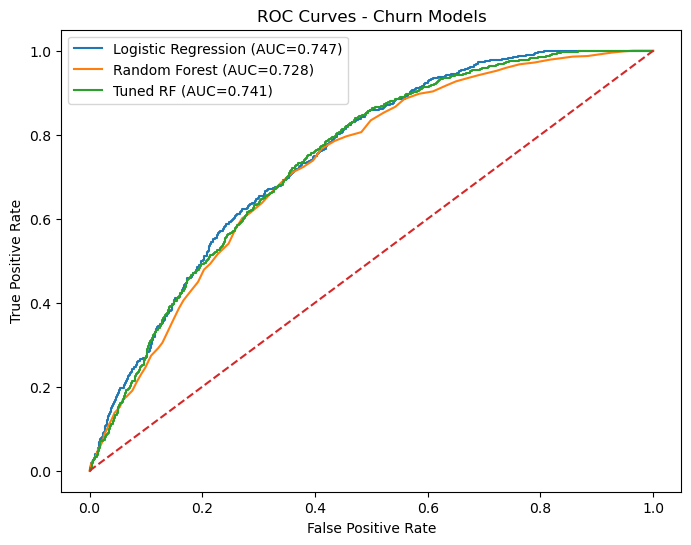

In [33]:
plt.figure(figsize=(8,6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_rf:.3f})')
plt.plot(fpr_best, tpr_best, label=f'Tuned RF (AUC={roc_best:.3f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Churn Models')
plt.legend()
plt.show()

# 8. Plot top feature importances

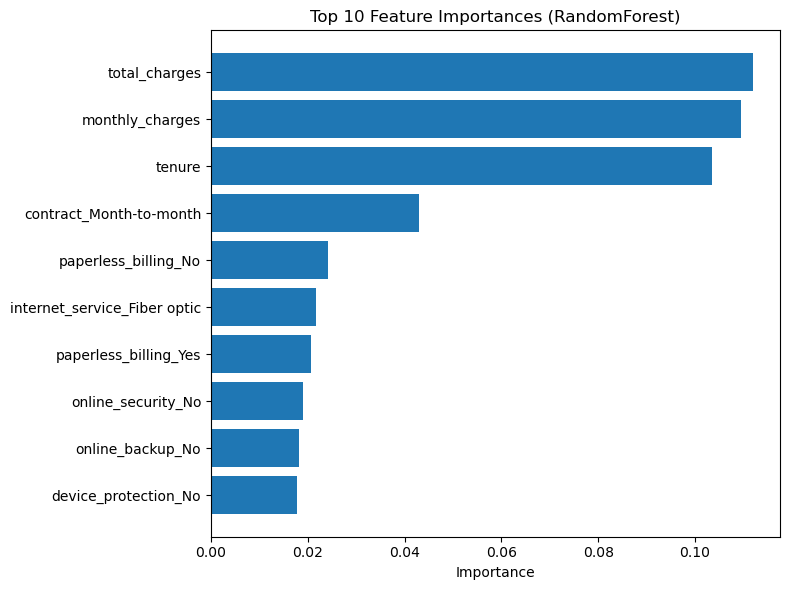

In [34]:
plt.figure(figsize=(8,6))
top = feat_imp.sort_values(by='importance', ascending=True).tail(10)
plt.barh(top['feature'], top['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()

# 9. Save best model

In [36]:
model_path = '../output/best_churn_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Saved best trained model to {model_path}")

# Provide file paths for user to download
csv_path = 'churn_data.csv'
print("\nFiles created:")
print(f" - Dataset CSV: {csv_path}")
print(f" - Best model pickle: {model_path}")

Saved best trained model to ../output/best_churn_model.pkl

Files created:
 - Dataset CSV: churn_data.csv
 - Best model pickle: ../output/best_churn_model.pkl
